<a href="https://colab.research.google.com/github/TWTIANTIAN/RRcourse2023/blob/main/titanic_classification_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Titanic classcification

To predict a classification- survival or not.

In [ ]:
import pandas as pd
import numpy as np

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualizationinin Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8


## The Data


In [ ]:
df = pd.read_csv('/content/titanic.csv')

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


# Exploratory Data Analysis

## Missing Data
create a simple heatmap to see where we are missing data!

In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
Siblings/Spouses Aboard,0
Parents/Children Aboard,0
Fare,0


There is no missing value

## Data distribution


<ipython-input-9-16fed14c4f8d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived',data=df,palette='RdBu_r')


<Axes: xlabel='Survived', ylabel='count'>

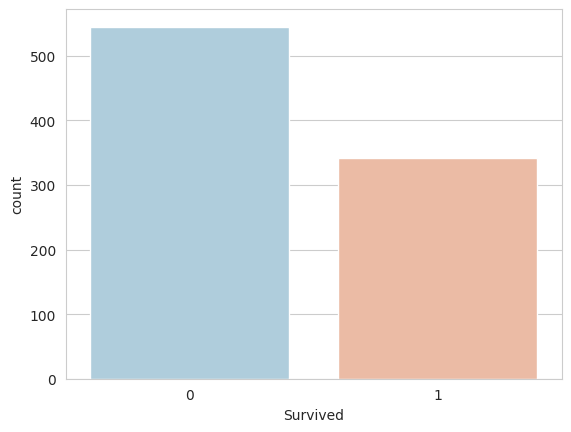

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=df,palette='RdBu_r')

It's no totally balanced data

<Axes: xlabel='Survived', ylabel='count'>

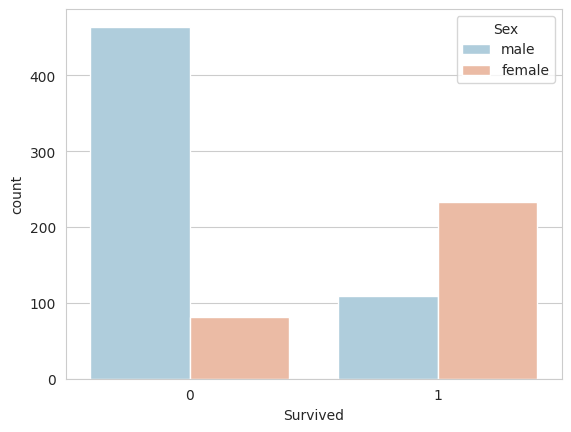

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=df,palette='RdBu_r')

Obviously, female tends to be survied, gender is quite a good explantory variable

<Axes: xlabel='Survived', ylabel='count'>

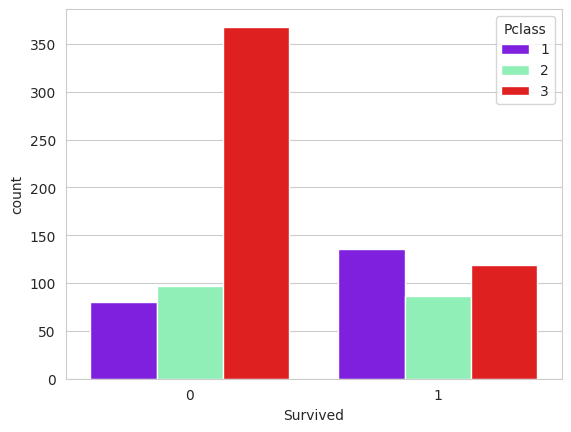

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=df,palette='rainbow')

Obviously, Pclass=1 tends to survive, Pclass=3 tends to die, so Pclass is also a good explantory variable

<Axes: >

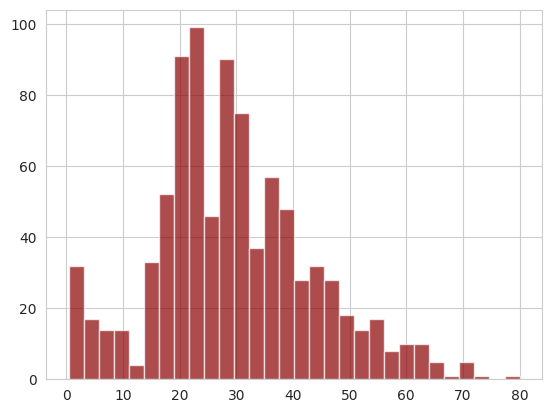

In [ ]:
df['Age'].hist(bins=30,color='darkred',alpha=0.7)

Age is concentrated around 20-40

<Axes: xlabel='Siblings/Spouses Aboard', ylabel='count'>

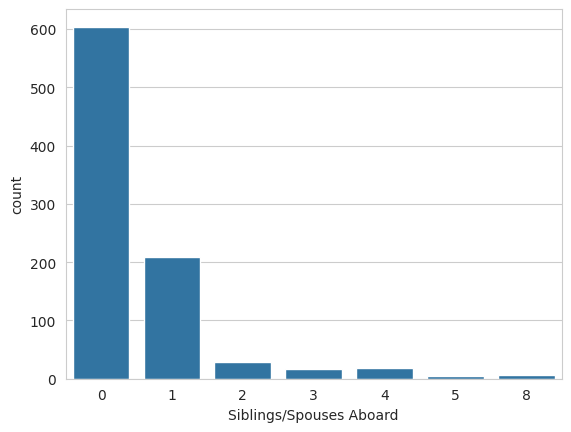

In [ ]:
sns.countplot(x='Siblings/Spouses Aboard',data=df)

<Axes: xlabel='Parents/Children Aboard', ylabel='count'>

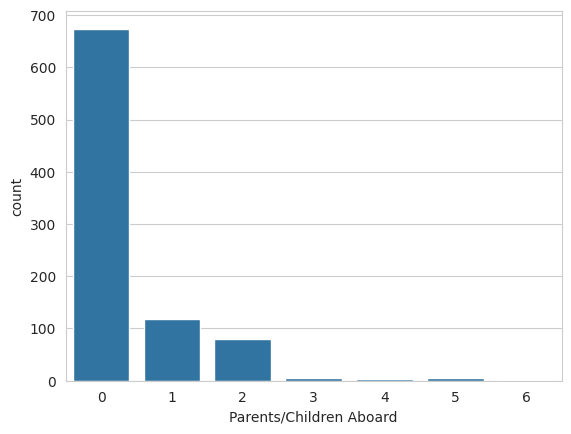

In [ ]:
sns.countplot(x='Parents/Children Aboard',data=df)

<Axes: >

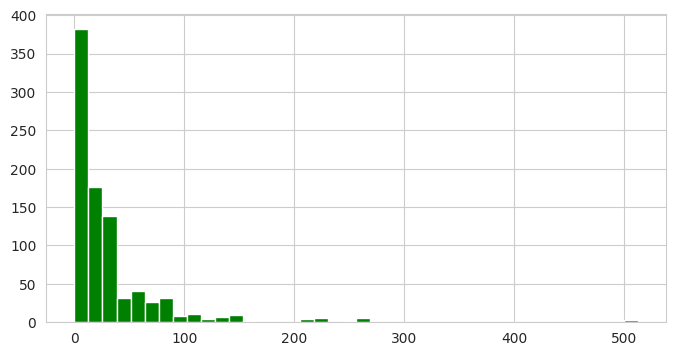

In [ ]:
df['Fare'].hist(color='green',bins=40,figsize=(8,4))

#  Feature Engineering

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
 8   FamilySize               887 non-null    int64  
 9   IsAlone                  887 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.4+ KB


Creating 2 features: family size and isalone

In [ ]:
###CREATE: Feature Engineering for train and test/validation dataset
df['FamilySize'] = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard'] + 1
df['IsAlone'] = 1 #initialize to yes/1 is alone
df['IsAlone'].loc[df['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

<ipython-input-88-176f00d28e80>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['IsAlone'].loc[df['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1
<ipython-input-88-176f00d28e80>:4: SettingWithCopyWarning: 
A 

Creating the title, only keep the Mr, Miss, Mrs

In [ ]:
#quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
df['Title']=df['Name'].str.split(".", expand=True)[0]

In [ ]:
print(df['Title'].value_counts())

Title
Mr              513
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


In [ ]:
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (df['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
df['Title'] = df['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(df['Title'].value_counts())
print("-"*10)


Title
Mr        513
Miss      182
Mrs       125
Master     40
Misc       27
Name: count, dtype: int64
----------


### Continuous variable bins

Discretizing a continuous variable into categorical bins

In [ ]:
#Fare Bins/Buckets using qcut
df['FareBin'] = pd.qcut(df['Fare'], 4)

#Age Bins/Buckets using cut
df['AgeBin'] = pd.cut(df['Age'].astype(int), 5)
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,FamilySize,IsAlone,Title,FareBin,AgeBin
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500,2,0,Mr,"(-0.001, 7.925]","(16.0, 32.0]"
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833,2,0,Mrs,"(31.138, 512.329]","(32.0, 48.0]"
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250,1,1,Miss,"(-0.001, 7.925]","(16.0, 32.0]"
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000,2,0,Mrs,"(31.138, 512.329]","(32.0, 48.0]"
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500,1,1,Mr,"(7.925, 14.454]","(32.0, 48.0]"


### Convert Formats¶
We will convert categorical data to dummy variables for mathematical analysis.

In [ ]:
label = LabelEncoder()
df['Sex_Code']=label.fit_transform(df['Sex'])
df['Title_Code'] = label.fit_transform(df['Title'])
df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])
df['FareBin_Code'] = label.fit_transform(df['FareBin'])

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500,2,0,Mr,"(-0.001, 7.925]","(16.0, 32.0]",1,3,1,0
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833,2,0,Mrs,"(31.138, 512.329]","(32.0, 48.0]",0,4,2,3
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250,1,1,Miss,"(-0.001, 7.925]","(16.0, 32.0]",0,2,1,0
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000,2,0,Mrs,"(31.138, 512.329]","(32.0, 48.0]",0,4,2,3
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500,1,1,Mr,"(7.925, 14.454]","(32.0, 48.0]",1,3,2,1


In [ ]:
#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features
data1_x = ['Sex','Pclass',  'Title','Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Age', 'Fare'] #pretty name/values for charts
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define new enginerred features to check whether it's better
data1_x_bin = ['Sex_Code','Pclass', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
df_dummy = pd.get_dummies(df[data1_xy])
data1_dummy = pd.get_dummies(df[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

df_dummy.head()


Original X Y:  ['Survived', 'Sex', 'Pclass', 'Title', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Age', 'Fare'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Survived,Pclass,Siblings/Spouses Aboard,Parents/Children Aboard,Age,Fare,Sex_female,Sex_male,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,0,3,1,0,22.0,7.2500,False,True,False,False,False,True,False
1,1,1,1,0,38.0,71.2833,True,False,False,False,False,False,True
2,1,3,0,0,26.0,7.9250,True,False,False,False,True,False,False
3,1,1,1,0,35.0,53.1000,True,False,False,False,False,False,True
4,0,3,0,0,35.0,8.0500,False,True,False,False,False,True,False


In [ ]:
data1_dummy[data1_x_dummy]

,Pclass,Siblings/Spouses Aboard,Parents/Children Aboard,Age,Fare,Sex_female,Sex_male,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,False,True,False,False,False,True,False
1,1,1,0,38.0,71.2833,True,False,False,False,False,False,True
2,3,0,0,26.0,7.9250,True,False,False,False,True,False,False
3,1,1,0,35.0,53.1000,True,False,False,False,False,False,True
4,3,0,0,35.0,8.0500,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
882,2,0,0,27.0,13.0000,False,True,False,True,False,False,False
883,1,0,0,19.0,30.0000,True,False,False,False,True,False,False
884,3,1,2,7.0,23.4500,True,False,False,False,True,False,False
885,1,0,0,26.0,30.0000,False,True,False,False,False,True,False


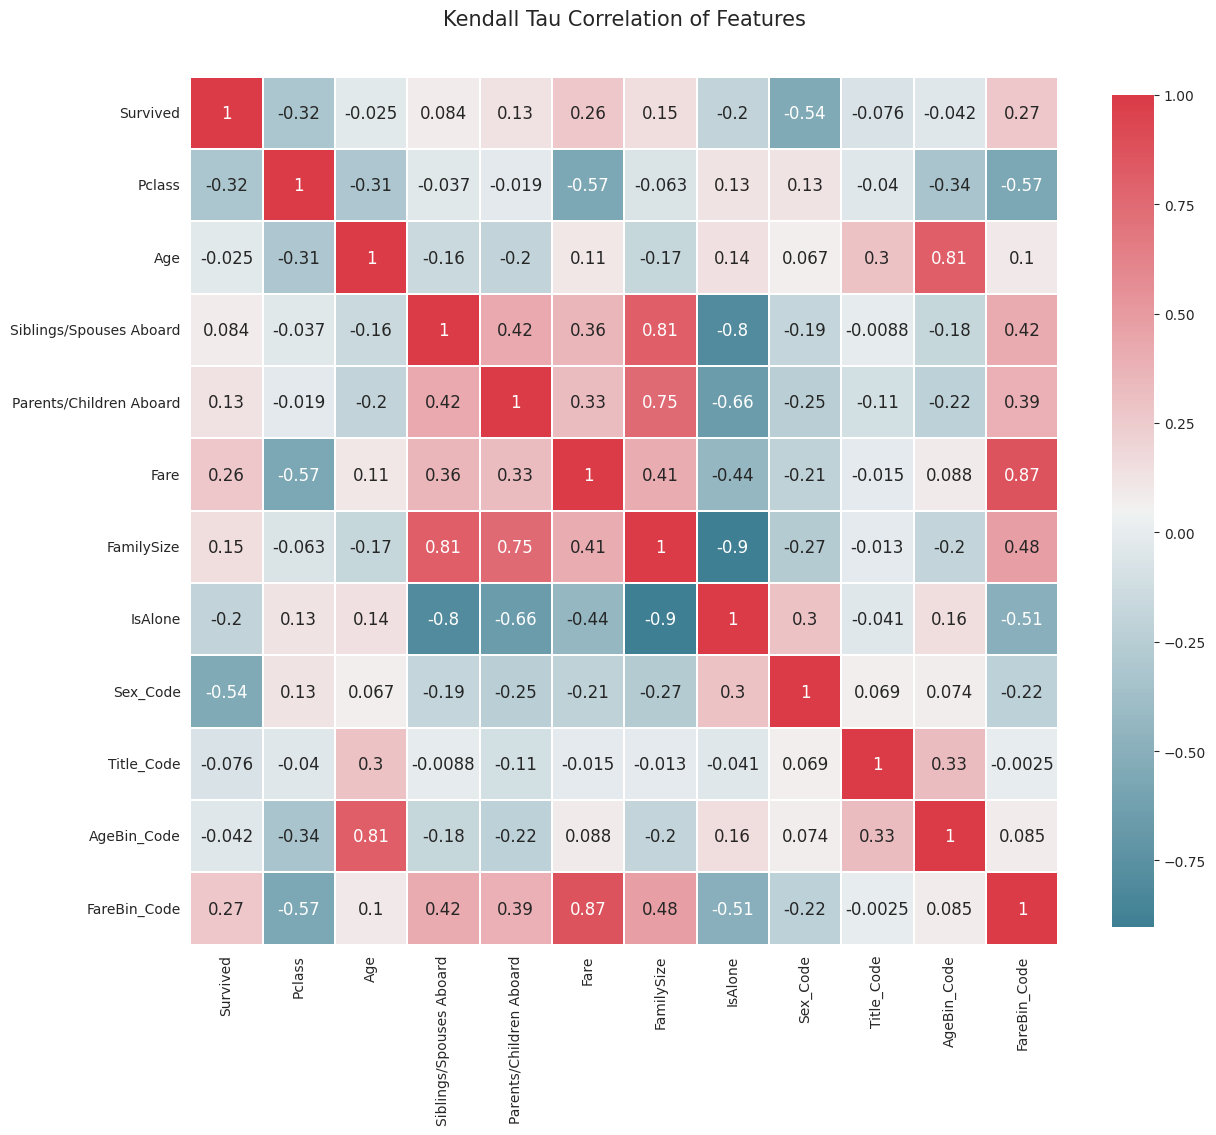

In [ ]:
def correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=[np.number])  # Ensuring only numeric data
    _, ax = plt.subplots(figsize=(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(
        numeric_df.corr(method='kendall'),  # Using Kendall's Tau correlation
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1, linecolor='white',
        annot_kws={'fontsize':12}
    )
    plt.title('Kendall Tau Correlation of Features', y=1.05, size=15)


correlation_heatmap(df)

Great! Our data is ready for our model!

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(df[data1_x_calc], df[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(df[data1_x_bin], df[Target] , random_state = 0)

print("Df Shape: {}".format(df.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))


train1_x.head()
train1_x_bin.head()

Df Shape: (887, 17)
Train1 Shape: (665, 7)
Test1 Shape: (222, 7)


,Sex_Code,Pclass,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
310,0,2,4,3,1,2
317,0,1,4,3,2,3
704,1,1,3,1,2,2
346,1,3,0,3,0,2
489,1,1,3,1,3,2


# Training and Predicting

I will use and compare different models: LogisticRegression， KNN, SVM, Ridge, Lasso, ElasticNet, Decision Tree, Random Forest, and XGBoost.
And also I will compare the original data and bin data

In [ ]:
from sklearn import ensemble, tree, linear_model, svm, neighbors
from sklearn.model_selection import ShuffleSplit, cross_validate
from xgboost import XGBClassifier
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

In [ ]:
MLA = [
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),

    # GLM
    linear_model.RidgeClassifierCV(),
    LogisticRegression(penalty='l1', solver='saga', max_iter=10000),  # Lasso-like logistic regression
    LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=10000),  # ElasticNet logistic regression
    linear_model.LogisticRegression(max_iter=1000),  #
    # Trees
    tree.DecisionTreeClassifier(),

    # Ensemble Methods
    ensemble.RandomForestClassifier(),

    # XGBoost
    XGBClassifier()
]


In [ ]:
# 定义原始数据和分箱数据的比较表
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Score Mean', 'MLA Test Score Mean', 'MLA Test Score 3*STD', 'MLA Time']
MLA_compare_bin = pd.DataFrame(columns = MLA_columns)
MLA_compare_original = pd.DataFrame(columns = MLA_columns)

# 定义模型预测表
MLA_predict_bin = df[Target]
MLA_predict_original = df[Target]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

In [ ]:
def evaluate_models(data, MLA_compare, MLA_predict, features):
    row_index = 0
    for alg in MLA:
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        # Using cross-validation to evaluate model performance
        cv_results = model_selection.cross_validate(alg, data[features], data[Target], cv=cv_split,
                                                    return_train_score=True,
                                                    scoring={'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'})
        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Score Mean'] = cv_results['train_accuracy'].mean()
        MLA_compare.loc[row_index, 'MLA Test Score Mean'] = cv_results['test_accuracy'].mean()
        MLA_compare.loc[row_index, 'MLA Test F1 Score Mean'] = cv_results['test_f1_weighted'].mean()
        MLA_compare.loc[row_index, 'MLA Test F1 Score 3*STD'] = cv_results['test_f1_weighted'].std() * 3

        # Save MLA predictions
        alg.fit(data[features], data[Target])
        MLA_predict[MLA_name] = alg.predict(data[features])

        row_index += 1

    # Print and sort the table
    MLA_compare.sort_values(by = ['MLA Test F1 Score Mean'], ascending = False, inplace = True)
    return MLA_compare

In [ ]:
evaluate_bin=evaluate_models(df, MLA_compare_bin, MLA_predict_bin, data1_x_bin)

In [ ]:
evaluate_original=evaluate_models(df_dummy, MLA_compare_original, MLA_predict_original, data1_x_dummy)

In [ ]:
print("Evaluation Results Using Original Data:")
print(evaluate_original)
print("\n")  # Adds an empty line for better separation of the outputs
print("Evaluation Results Using Binned Data:")
print(evaluate_bin)

Evaluation Results Using Original Data:
                 MLA Name                                     MLA Parameters  \
3       RidgeClassifierCV  {'alphas': (0.1, 1.0, 10.0), 'class_weight': N...   
6      LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   
9           XGBClassifier  {'objective': 'binary:logistic', 'base_score':...   
8  RandomForestClassifier  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
2                   NuSVC  {'break_ties': False, 'cache_size': 200, 'clas...   
5      LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   
4      LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   
7  DecisionTreeClassifier  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   
0    KNeighborsClassifier  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
1                     SVC  {'C': 1.0, 'break_ties': False, 'cache_size': ...   

  MLA Train Score Mean MLA Test Score Mean MLA Test Score 3*STD  MLA Time  \
3 

The analysis of models on binned data shows a notable enhancement in model performance, particularly with ensemble models like RandomForest and gradient boosting models like XGBoost. This outcome supports the strategy of using binned data for complex datasets where raw numerical values may not directly capture the underlying patterns as effectively.

Text(0, 0.5, 'Algorithm')

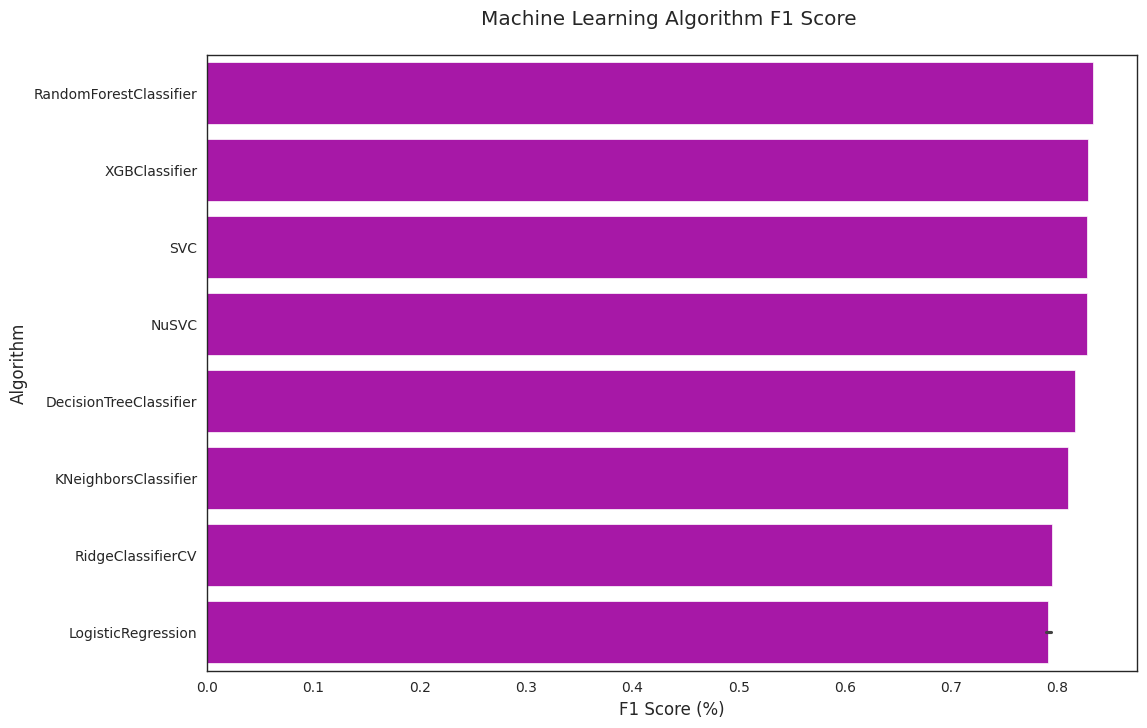

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test F1 Score Mean', y = 'MLA Name', data = evaluate_bin, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm F1 Score \n')
plt.xlabel('F1 Score (%)')
plt.ylabel('Algorithm')

#  Tune Optimal Model with Hyper-Parameters

Using GridSearchCV:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search_rf.fit(train1_x_bin, train1_y_bin)  # Assuming X and y are your features and labels

# Print the best parameters and best score
print("Best parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 score for RandomForest:", grid_search_rf.best_score_)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
331 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best parameters for RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 score for RandomForest: 0.8425880083272725


In [ ]:
from xgboost import XGBClassifier

# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Setup the GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search_xgb.fit(train1_x_bin, train1_y_bin)  # Assuming X and y are your features and labels

# Print the best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best F1 score for XGBoost:", grid_search_xgb.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}
Best F1 score for XGBoost: 0.8392244557850832


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:44:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluate on Test Data

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Predictions
y_pred_rf = grid_search_rf.predict(test1_x_bin)
y_pred_xgb = grid_search_xgb.predict(test1_x_bin)

# Evaluation
print("RandomForest Test Accuracy:", accuracy_score(test1_y_bin, y_pred_rf))
print("RandomForest Test F1 Score:", f1_score(test1_y_bin, y_pred_rf, average='weighted'))

print("XGBoost Test Accuracy:", accuracy_score(test1_y_bin, y_pred_xgb))
print("XGBoost Test F1 Score:", f1_score(test1_y_bin, y_pred_xgb, average='weighted'))

if len(set(y_pred_rf)) == 2:  # Just a simple check for binary classification
    print("RandomForest Test ROC-AUC:", roc_auc_score(test1_y_bin, grid_search_rf.predict_proba(test1_x_bin)[:, 1]))
    print("XGBoost Test ROC-AUC:", roc_auc_score(test1_y_bin, grid_search_xgb.predict_proba(test1_x_bin)[:, 1]))

# Detailed classification report
print("RandomForest Classification Report:")
print(classification_report(test1_y_bin, y_pred_rf))

print("XGBoost Classification Report:")
print(classification_report(test1_y_bin, y_pred_xgb))


RandomForest Test Accuracy: 0.8243243243243243
RandomForest Test F1 Score: 0.8224185373973124
XGBoost Test Accuracy: 0.8198198198198198
XGBoost Test F1 Score: 0.8175464577771716
RandomForest Test ROC-AUC: 0.890757042253521
XGBoost Test ROC-AUC: 0.8645246478873241
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       142
           1       0.78      0.71      0.75        80

    accuracy                           0.82       222
   macro avg       0.81      0.80      0.81       222
weighted avg       0.82      0.82      0.82       222

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       142
           1       0.78      0.70      0.74        80

    accuracy                           0.82       222
   macro avg       0.81      0.79      0.80       222
weighted avg       0.82      0.82      0.82       222



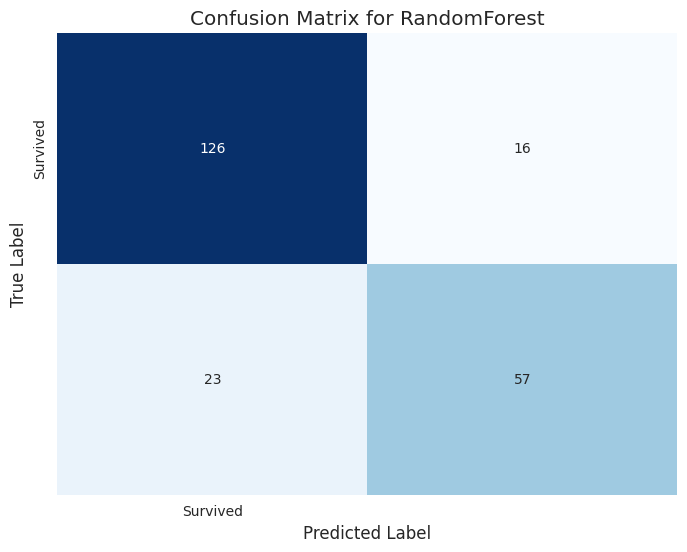

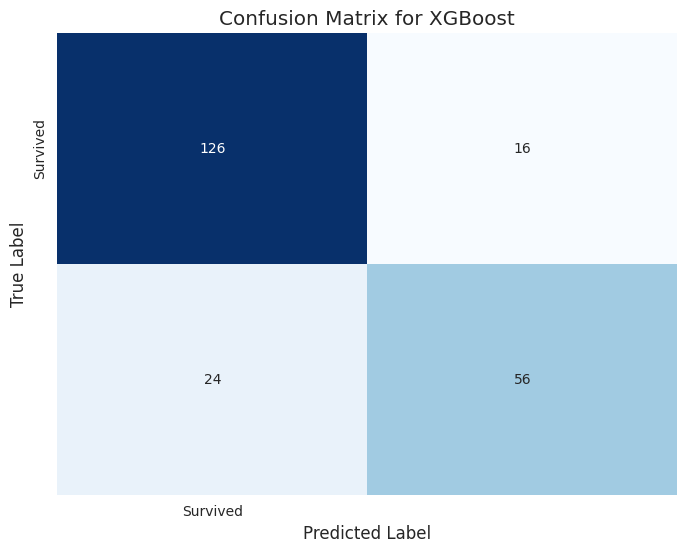

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For better visualization of the confusion matrix
# Confusion Matrices
cm_rf = confusion_matrix(test1_y_bin, y_pred_rf)
cm_xgb = confusion_matrix(test1_y_bin, y_pred_xgb)

# Define class labels if not already
class_labels = list(set(test1_y_bin))  # This automatically grabs unique classes from y_test

# Plotting function
def plot_confusion_matrix(cm, model_name, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Execute plotting
plot_confusion_matrix(cm_rf, 'RandomForest', class_labels)
plot_confusion_matrix(cm_xgb, 'XGBoost', class_labels)